# Setup a game
The board can be represented by a matrix where zero indicates empty space and plus or minus one indicates the pieces of player one and player two. Given that there are only circles and crosses in tic-tac-toe, each entry can then only be zero, plus one, or minus one.
We can also encode the final outcome by a score,where plus one indicates a win by the first player,
and negative one indicates a win by the second player, and zero indicates a draw.

In [1]:
from ConnectN import ConnectN
grid_size = 3
win_size = 3
game_setting = {'size':(grid_size,grid_size), 'N':win_size}
game = ConnectN(**game_setting)

In [2]:
game.move((0,1))
print(game.state)
print(game.player)
print(game.score)

[[ 0.  1.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
-1
None


In [3]:
# player -1 move
game.move((0,0))
# player +1 move
game.move((1,1))
# player -1 move
game.move((1,0))
# player +1 move
game.move((2,1))

print(game.state)
print(game.player)
print(game.score)

[[-1.  1.  0.]
 [-1.  1.  0.]
 [ 0.  1.  0.]]
1
1


# Play a game interactively

<IPython.core.display.Javascript object>


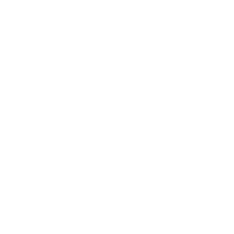

In [4]:
% matplotlib notebook

from Play import Play


gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=None)


# Initialize a network to play the game
We need to define a policy for tic-tac-toe, that takes the game state as input, and outputs a policy and a critic

In [5]:
from Policy import Policy
policy = Policy()

## Define a player that uses MCTS and the expert policy + critic to play a game

We've introduced a new parameter
$T$ = temperature (0 = , 1 = )



This tells us how to choose the next move based on the MCTS results

$$p_a = \frac{N_a^{\frac{1}{T}}}{\sum_a N_a^{\frac{1}{T}}}$$

$T \rightarrow 0$, we choose action with largest $N_a$. 



In [6]:
import MCTS

from copy import copy
import random

def Policy_Player_MCTS(game):
    """"From the top-node at current state, loop for some iterations:
    Start from the top-node, repeatedly pick the child-node with largest U (expected value + exploration term)
    If N (visit count) = 0 for the node, play a random game
    Else, expand node, play a random game from a randomly selected child
    Update statistics, back-propagate and update N and U as needed
    Select move with highest N
    """
    mytree = MCTS.Node(copy(game))
    for _ in range(50):
        mytree.explore(policy)
   
    mytreenext, (v, nn_v, p, nn_p) = mytree.next(temperature=0.1)
        
    return mytreenext.game.last_move

def Random_Player(game):
    return random.choice(game.available_moves())    


In [7]:
game = ConnectN(**game_setting)
print(game.state)
Policy_Player_MCTS(game)

[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]


C:\Users\Hewitt\Documents\GitHub\Reinforcement-Learning\Alpha-Zero-TicTacToe\MCTS.py:68: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  return game.available_moves(), tinv(prob)[mask].view(-1), v.squeeze().squeeze()


(2, 0)

# Play a game against the policy

<IPython.core.display.Javascript object>


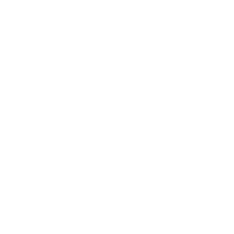

In [8]:
% matplotlib notebook


gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=Policy_Player_MCTS)


# Training Loop

In [9]:
game=ConnectN(**game_setting)
policy = Policy()

## Note:
code up the alphazero loss function, defined to be
$$L = \sum_t \left\{ (v^{(t)}_\theta - z)^2  - \sum_a p^{(t)}_a \log \pi_\theta(a|s_t) \right\} + \textrm{constant}$$ 
I added a constant term $\sum_t \sum_a p^{(t)}\log p^{(t)}$ so that when $v_\theta^{(t)} = z$ and $p^{(t)}_a = \pi_\theta(a|s_t)$, $L=0$, this way we can have some metric of progress.

In [10]:
import numpy as np
# train our agent
episodes = 400
outcomes = []
losses = []

!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episodes).start()

for e in range(episodes):

    mytree = MCTS.Node(game)
    vterm = []
    logterm = []
    
    while mytree.outcome is None:
        mytree, vterm, logterm = mytree.step(policy, vterm, logterm)
        
    outcome = mytree.outcome
    loss = policy.optimize(mytree,vterm,logterm)
    outcomes.append(outcome)
    losses.append(loss)
    
    if (e+1)%50==0:
        print("game: ",e+1, ", mean loss: {:3.2f}".format(np.mean(losses[-20:])),
              ", recent outcomes: ", outcomes[-10:])
    del loss
    
    timer.update(e+1)
    
    
timer.finish()




C:\Users\Hewitt\Documents\GitHub\Reinforcement-Learning\Alpha-Zero-TicTacToe\MCTS.py:68: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  return game.available_moves(), tinv(prob)[mask].view(-1), v.squeeze().squeeze()
C:\Users\Hewitt\Anaconda3\envs\drlnd\lib\site-packages\torch\autograd\__init__.py:149: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


game:  50 , mean loss: 4.91 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  100 , mean loss: 0.37 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  150 , mean loss: 0.05 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  200 , mean loss: 0.04 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  250 , mean loss: 0.02 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  300 , mean loss: 0.02 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  350 , mean loss: 0.01 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


game:  400 , mean loss: 0.01 , recent outcomes:  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


training loop: 100% |###########################################| Time: 0:00:14


<IPython.core.display.Javascript object>


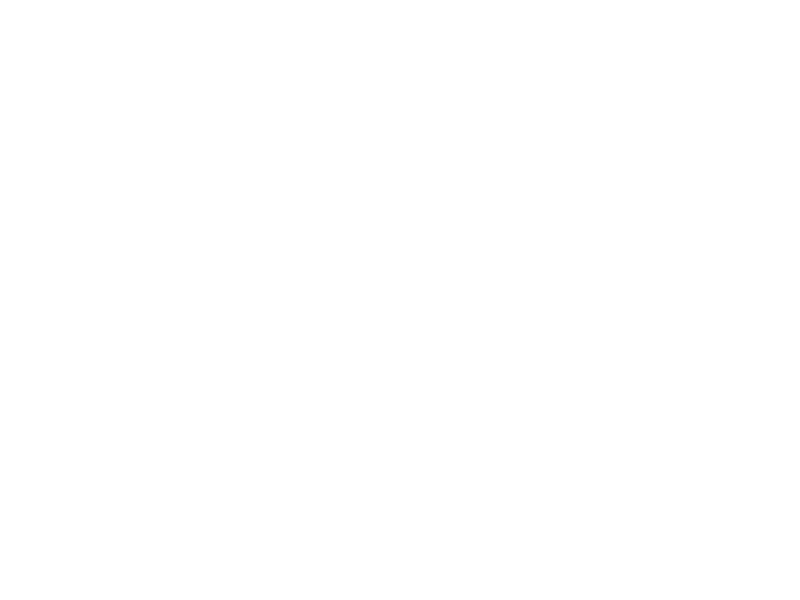

In [11]:
# plot your losses

import matplotlib.pyplot as plt

% matplotlib notebook
plt.plot(losses)
plt.show()


# Play a game against your alphazero agent !

<IPython.core.display.Javascript object>


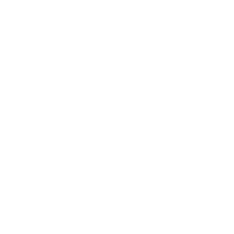

In [12]:
% matplotlib notebook

# as first player
gameplay=Play(ConnectN(**game_setting), 
              player1=None, 
              player2=Policy_Player_MCTS)


<IPython.core.display.Javascript object>


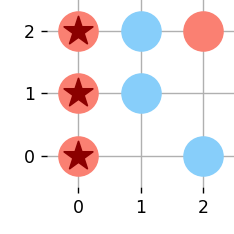

C:\Users\Hewitt\Documents\GitHub\Reinforcement-Learning\Alpha-Zero-TicTacToe\MCTS.py:68: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  return game.available_moves(), tinv(prob)[mask].view(-1), v.squeeze().squeeze()


In [13]:
% matplotlib notebook

# as second player

gameplay=Play(ConnectN(**game_setting), 
              player2=None, 
              player1=Policy_Player_MCTS)
